<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #03020e;">
    <h1 id = "title"
        style = "padding: 18px; 
                 color: White;
                 font-size: 30px;
                 font-family: Times New Roman;
                 font-weight: bold;">Brain MRI Segmentation | U-Net and DeepLab | TF
        <a class="anchor-link" id="title" href="https://www.kaggle.com/code/harits/brain-mri-segmentation-u-net-and-deeplab-tf#title">¶</a>
    </h1>
</div>

<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #335981;">
    <h1 id = "preparation"
        style = "padding: 15px; 
                 color: White;
                 font-size: 26px;
                 font-family: Times New Roman;
                 font-weight: bold;">1. | Preparation 🍳
        <a class="anchor-link" id="preparation" href="https://www.kaggle.com/code/harits/brain-mri-segmentation-u-net-and-deeplab-tf#preparation">¶</a>
    </h1>
</div>

In [1]:
# Import Libraries

# Main
import os
import glob
import cv2
import numpy as np
import pandas as pd
import gc
import time
from PIL import Image

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Reshape, concatenate, Concatenate
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Warning
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Configuration
IMG_WIDTH = 240
IMG_HEIGHT = 240
IMG_CHANNELS = 1
NUM_CLASSES = 2
BATCH_SIZE = 16
EPOCHS = 1

<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #335981;">
    <h1 id = "dataset"
        style = "padding: 15px; 
                 color: White;
                 font-size: 26px;
                 font-family: Times New Roman;
                 font-weight: bold;">2. | Dataset 📊
        <a class="anchor-link" id="dataset" href="https://www.kaggle.com/code/harits/brain-mri-segmentation-u-net-and-deeplab-tf#dataset">¶</a>
    </h1>
</div>

In [5]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andrewmvd/brain-tumor-segmentation-in-mri-brats-2015

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 7.82G/7.82G [04:42<00:00, 27.2MB/s]
100% 7.82G/7.82G [04:42<00:00, 29.7MB/s]


In [6]:
!unzip /content/brain-tumor-segmentation-in-mri-brats-2015.zip

Archive:  /content/brain-tumor-segmentation-in-mri-brats-2015.zip
  inflating: MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii  
  inflating: MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii  
  inflating: MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii  
  inflating: MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii  
  inflating: MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii  
  inflating: MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_flair.nii  
  inflating: MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_seg.nii  
  inflating: MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_t1.nii  
  inflating: MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_t1ce.nii  
  inflating: MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Trai

In [7]:
!rm -R /content/MICCAI_BraTS_2018_Data_Training
!rm -R /content/MICCAI_BraTS_2019_Data_Training
!rm -R /content/brain-tumor-segmentation-in-mri-brats-2015.zip

rm: cannot remove '/content/MICCAI_BraTS_2019_Data_Training': No such file or directory


In [8]:
import nibabel as nib

In [ ]:
import os

data_dir = '/content/MICCAI_BraTS2020_TrainingData/'
img_add = os.path.join(data_dir, "BraTS20_Training_001/BraTS20_Training_001_flair.nii")
label_add = os.path.join(data_dir, "BraTS20_Training_001/BraTS20_Training_001_seg.nii")

img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
print(f"image shape: {img.shape}, label shape: {label.shape}")
j = 50
plt.figure("image", (36, 20))
for i in range(0, 100, 2):
    plt.subplot(15, 10, i+1)
    plt.title("image")
    plt.imshow(img[:, :, j], cmap="gray")
    plt.subplot(15, 10, i+2)
    plt.title("label")
    plt.imshow(label[:, :, j])
    j += 1
plt.show()

In [60]:
type(img)

numpy.memmap

<div>
    <h2 style = "padding: 15px; 
                 color: #335981;
                 font-size: 25px;
                 font-family: Times New Roman;
                 font-weight: bold;">2.1. Metadata
    </h2>
</div>

In [17]:
# from google.colab import drive
# drive.mount('/content/drive')

In [17]:
from tqdm.notebook import tqdm

In [18]:
metadata = pd.read_csv('/content/MICCAI_BraTS2020_TrainingData/survival_info.csv')
# display(metadata)
# metadata.info()
metadata.columns

Index(['Brats20ID', 'Age', 'Survival_days', 'Extent_of_Resection'], dtype='object')

In [19]:
# list(metadata['Brats20ID'] + '_flair.nii')
# list(metadata['Brats20ID'] + '_seg.nii')

In [20]:
# data_map = []
# for sub_dir_path in glob.glob("/content/drive/MyDrive/DIP_Dataset_Brain/kaggle_3m/*"):
#     if os.path.isdir(sub_dir_path):
#         dirname = sub_dir_path.split("/")[-1]
#         for filename in os.listdir(sub_dir_path):
#             image_path = sub_dir_path + "/" + filename
#             data_map.extend([dirname, image_path])

# df = pd.DataFrame({
#     "patient_id" : data_map[::2],
#     "path" : data_map[1::2]
# })

# df

In [21]:
# df_images = df[~df['path'].str.contains("mask")]
# df_masks = df[df['path'].str.contains("mask")]

# BASE_LEN = 89
# END_IMG_LEN = 4
# END_MASK_LEN = 9

# images = sorted(df_images["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
# masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

df_brain = pd.DataFrame({
    "image_path": list(data_dir + metadata['Brats20ID'] + '/' + metadata['Brats20ID'] + '_flair.nii'),
    "mask_path": list(data_dir + metadata['Brats20ID'] + '/' + metadata['Brats20ID'] + '_seg.nii')
})

In [22]:
df_brain.head()

,image_path,mask_path
0,/content/MICCAI_BraTS2020_TrainingData/BraTS20...,/content/MICCAI_BraTS2020_TrainingData/BraTS20...
1,/content/MICCAI_BraTS2020_TrainingData/BraTS20...,/content/MICCAI_BraTS2020_TrainingData/BraTS20...
2,/content/MICCAI_BraTS2020_TrainingData/BraTS20...,/content/MICCAI_BraTS2020_TrainingData/BraTS20...
3,/content/MICCAI_BraTS2020_TrainingData/BraTS20...,/content/MICCAI_BraTS2020_TrainingData/BraTS20...
4,/content/MICCAI_BraTS2020_TrainingData/BraTS20...,/content/MICCAI_BraTS2020_TrainingData/BraTS20...


In [23]:
temp_df_frame = df_brain

In [24]:
df_brain = temp_df_frame[:200]
# df_brain

In [25]:
df_brain.iloc[0]['image_path']

'/content/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii'

In [26]:
# def pos_neg_diagnosis(mask_path):
#     value = np.max(cv2.imread(mask_path))
#     if value > 0 : 
#         return 1
#     return 0

# df_brain["diagnosis"] = df_brain["mask_path"].apply(lambda x: pos_neg_diagnosis(x))

# df_brain

<div>
    <h2 style = "padding: 15px; 
                 color: #335981;
                 font-size: 25px;
                 font-family: Times New Roman;
                 font-weight: bold;">2.2. Data Exploration
    </h2>
</div>

In [27]:
# # Create Figure
# fig = go.Figure()

# # Create Bar Chart
# diagnosis_count = df_brain["diagnosis"].value_counts()
# diagnosis_percentage = (diagnosis_count / diagnosis_count.sum()) * 100
# fig.add_trace(
#     go.Bar(
#         x=[str(x) for x in diagnosis_count.index.tolist()],
#         y=diagnosis_count.values,
#         marker_color=["#309cd4", "#03020e"],
#         text=[f"{percentage:.2f}%" for percentage in diagnosis_percentage],
#         textfont_size=20,
#         textfont_color="white"
#     )
# )

# # Update Axes
# fig.update_xaxes(showgrid=False, linecolor='black', title_text='Diagnosis')
# fig.update_yaxes(showgrid=False, linecolor='black')

# # Update Layout
# fig.update_layout(title_text="Brain Tumor Distribution", title_x=0.5, font_family="Times New Roman",
#                   width=600, height=400,
#                   plot_bgcolor='White'
# )

# # Show
# fig.show(iframe="connected")

In [28]:
# df_patient_tumor = df_brain[df_brain["diagnosis"]==1].reset_index(drop=True)
# df_patient_tumor.head(1)

In [29]:
# df_patient_num_dns = df_patient_tumor.groupby("patient_id")["diagnosis"].sum().reset_index().sort_values(by="diagnosis", ascending=False).reset_index(drop=True)
# df_patient_num_dns

In [30]:
# patient_id = df_patient_num_dns[df_patient_num_dns["diagnosis"]==49]["patient_id"].iloc[0, ]
# df_patient_one = df_brain[df_brain["patient_id"]==patient_id].reset_index(drop=True)
# display(df_patient_one.head())
# df_patient_one.shape

In [31]:
# def frame_image(img, frame_width):
#     b = frame_width # border size in pixel
#     ny, nx = img.shape[0], img.shape[1] # resolution / number of pixels in x and y
#     framed_img = Image.new('RGB', (b+ny+b, b+nx+b), (255, 0, 0)) # RGB color tuple
#     framed_img = np.array(framed_img.getdata()).reshape(framed_img.size[0], framed_img.size[1], 3)
#     framed_img[b:-b, b:-b] = img
#     return framed_img

# fig, axs = plt.subplots(4, 9, figsize=(13, 8))

# for i in range(df_patient_one.shape[0]):
#     mri_sm = cv2.imread(df_patient_one["image_path"][i])
#     if(df_patient_one["diagnosis"][i]==1): # Tumor
#         axs[i//9, i%9].imshow(frame_image(mri_sm, 13))
#         axs[i//9, i%9].set_title("Tumor", fontsize=7.5)
#     else: # No Tumor
#         axs[i//9, i%9].imshow(mri_sm)
        
#     axs[i//9, i%9].axis("off")

# # Title
# plt.suptitle("Image Visualization", x=0.5, y=0.92)

# # Show
# plt.show()

<div>
    <h2 style = "padding: 15px; 
                 color: #335981;
                 font-size: 25px;
                 font-family: Times New Roman;
                 font-weight: bold;">2.3. Data Preprocessing
    </h2>
</div>

In [32]:
from tqdm import tqdm_notebook as tqdm

In [33]:
# df_brain_train = df_brain.drop(columns=['patient_id'])
df_brain_train, df_brain_test = train_test_split(df_brain, test_size=0.1, random_state=2023)

In [35]:
img = list(df_brain_train['image_path'])[0]
img = nib.load(img).get_fdata()
img = img / 255

In [42]:
def get_data(img_path, mask_path):
    X_train = []
    Y_train = []

    for i in tqdm(range(len(img_path))):
        img = nib.load(img_path[i]).get_fdata()
        img = img[:, :, 76]
        img = np.expand_dims(img, axis=-1)
        img = img / 255

        mask = nib.load(mask_path[i]).get_fdata()
        mask = mask[:, :, 76]
        mask = np.expand_dims(mask, axis=-1)
        mask = mask / 255.

        X_train.append(img)
        Y_train.append(mask)

    return np.array(X_train), np.array(Y_train)

# Training Dataset
train_img_path = list(df_brain_train["image_path"])
train_mask_path = list(df_brain_train["mask_path"])

X_train, Y_train = get_data(train_img_path, train_mask_path)

# Testing Dataset
test_img_path = list(df_brain_test["image_path"])
test_mask_path = list(df_brain_test["mask_path"])

X_test, Y_test = get_data(test_img_path, test_mask_path)

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [44]:
X_train[0].shape
X_test[0].shape

(240, 240, 1)

<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #335981;">
    <h1 id = "image-segmentation"
        style = "padding: 15px; 
                 color: White;
                 font-size: 26px;
                 font-family: Times New Roman;
                 font-weight: bold;">3. | Image Segmentation 🍁
        <a class="anchor-link" id="image-segmentation" href="https://www.kaggle.com/code/harits/brain-mri-segmentation-u-net-and-deeplab-tf#image-segmentation">¶</a>
    </h1>
</div>

<div>
    <h2 style = "padding: 15px; 
                 color: #335981;
                 font-size: 25px;
                 font-family: Times New Roman;
                 font-weight: bold;">3.1. Helper Function
    </h2>
</div>

In [45]:
# Loss and Metrics
def bce_loss(y_true, y_pred):
    y_true = tf.keras.backend.cast(y_true, 'float32')
    y_pred = tf.keras.backend.cast(y_pred, 'float32')
    
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)

def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    
    y_true_f = tf.keras.backend.cast(y_true_f, 'float32')
    y_pred_f = tf.keras.backend.cast(y_pred_f, 'float32')
    
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice_coef_v = (2. * intersection + 1.) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1.)
    return dice_coef_v

def dice_loss(y_true, y_pred):
    dice_loss_v = 1 - dice_coef(y_true, y_pred)
    return dice_loss_v

def bce_dice_loss(y_true, y_pred):
    bce_dice_loss_v = bce_loss(y_true, y_pred) + dice_loss(y_true, y_pred)
    return bce_dice_loss_v

bce_dice_loss(tf.constant([1., 1., 0.9]), 
              tf.constant([1., 1., 1.]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.52560085>

In [46]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=15
)

<div>
    <h2 style = "padding: 15px; 
                 color: #335981;
                 font-size: 25px;
                 font-family: Times New Roman;
                 font-weight: bold;">3.6. DeepLab V3+
    </h2>
</div>

In [47]:
def aspp_v3(inputs, atrous_rates):
    aspp_layers = []
    for rate in atrous_rates:
        aspp_layer = Conv2D(1, 3, activation='relu', padding='same', dilation_rate=rate)(inputs)
        aspp_layers.append(aspp_layer)

    # Add Image-Level features
    img_level = GlobalAveragePooling2D()(inputs)
    img_level = Reshape((1, 1, -1))(img_level)
    img_level = Conv2D(1, 1, activation='relu', padding='same')(img_level)
    img_level = UpSampling2D(size=tf.keras.backend.int_shape(inputs)[1:3], interpolation='bilinear')(img_level)
    
    aspp_layers.append(img_level)
    concat = Concatenate(axis=-1)(aspp_layers)
    return concat

def build_deeplabv3_plus_model():
    atrous_rates = [6, 12, 18, 24]
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    # Atrous Spatial Pyramid Pooling (ASPP)
    aspp_output = aspp_v3(conv5, atrous_rates)

    # Decoder
    upsample_aspp = Conv2DTranspose(256, kernel_size=4, strides=4, padding='same', activation='relu')(aspp_output)
    low_level_features = Conv2D(48, 1, activation='relu', padding='same')(pool2)
    concat = Concatenate(axis=-1)([upsample_aspp, low_level_features])
    decoder_conv = Conv2D(256, 3, activation='relu', padding='same')(concat)
    upsample = Conv2DTranspose(1, kernel_size=16, strides=4, padding='same')(decoder_conv)
    outputs = Conv2D(1, 1, activation='sigmoid')(upsample)

    model = Model(inputs=inputs, outputs=outputs)
    
    display(tf.keras.utils.plot_model(model, to_file='deeplabv3_plus.png', show_shapes=True))
    
    return model

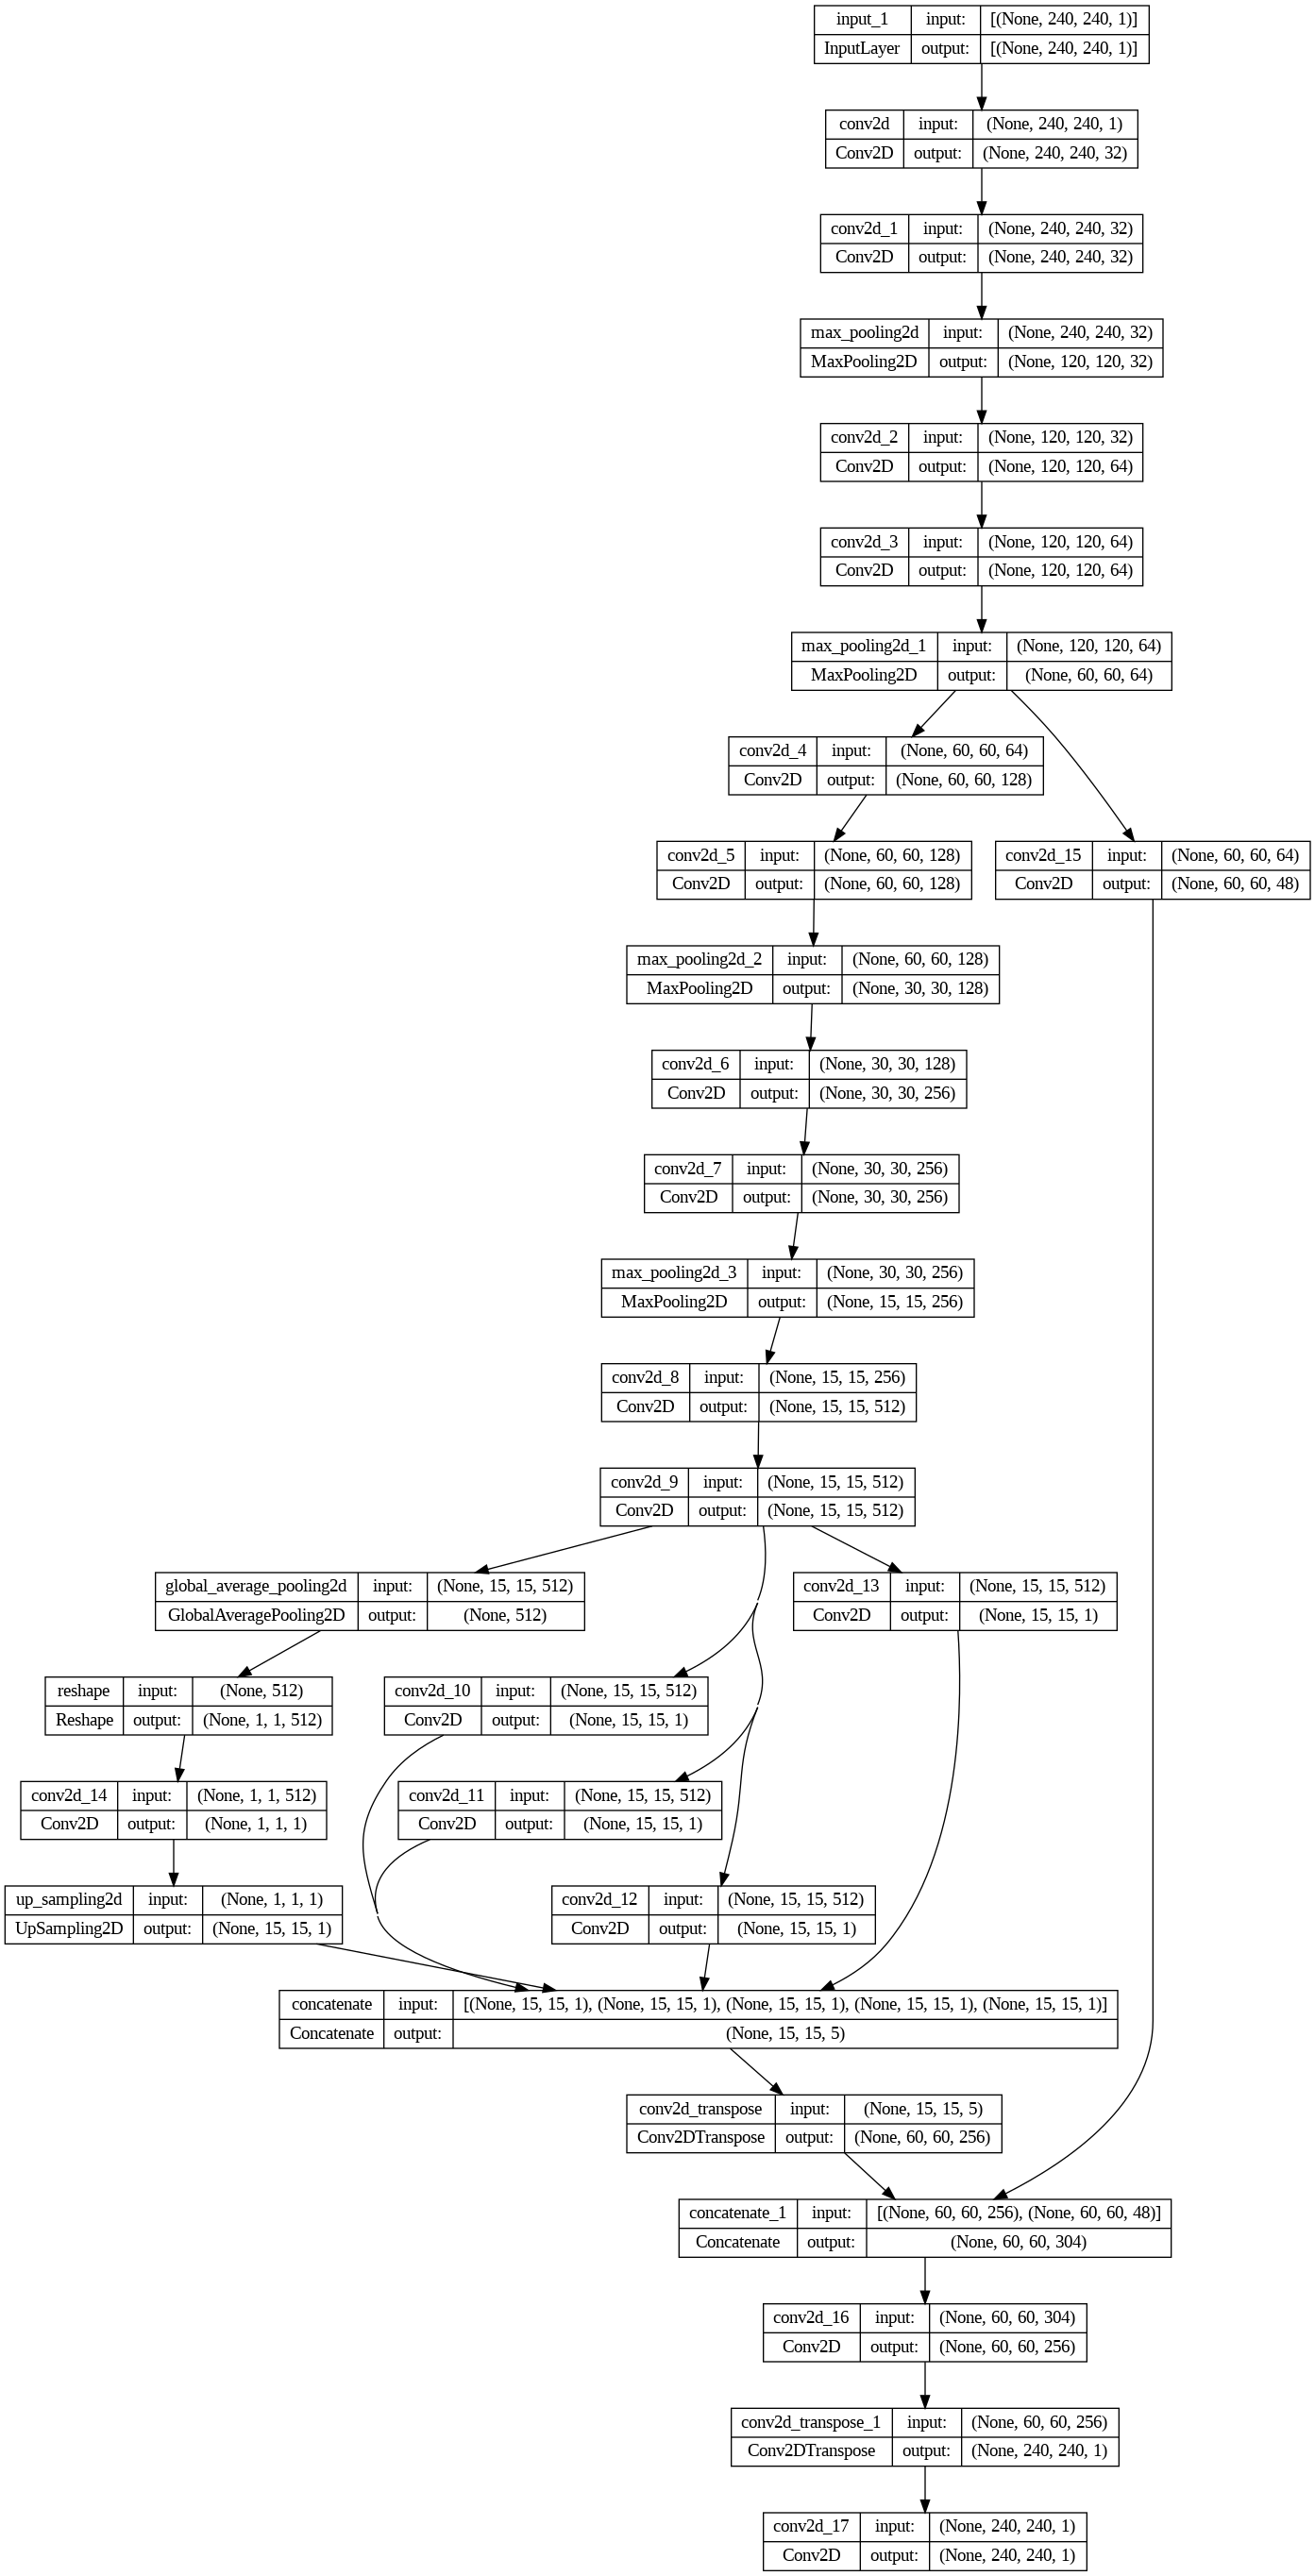

In [48]:
deeplabv3_plus_model = build_deeplabv3_plus_model()

In [50]:
# Model Compiling
deeplabv3_plus_model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=bce_dice_loss, 
    metrics=[dice_coef]
)

# Callback
model_checkpoint = ModelCheckpoint(
    "best_deeplabv3_plus_model.h5", 
    monitor="val_loss", 
    mode="min", 
    verbose=1,
    save_best_only=True
)

callbacks = [early_stopping, model_checkpoint]

# Training
start_time = time.time()
deeplabv3_plus_history = deeplabv3_plus_model.fit(
    X_train, 
    Y_train, 
    batch_size=BATCH_SIZE, 
    epochs=10, 
    validation_split=1/9,
    callbacks=callbacks
)
end_time = time.time()
deeplabv3_plus_time = end_time-start_time

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.0314 - dice_coef: 0.0029
Epoch 1: val_loss improved from inf to 1.01933, saving model to best_deeplabv3_plus_model.h5
10/10 [==============================] - 9s 230ms/step - loss: 1.0314 - dice_coef: 0.0029 - val_loss: 1.0193 - val_dice_coef: 0.0075
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 1.0066 - dice_coef: 0.0039
Epoch 2: val_loss improved from 1.01933 to 1.00154, saving model to best_deeplabv3_plus_model.h5
10/10 [==============================] - 2s 175ms/step - loss: 1.0066 - dice_coef: 0.0039 - val_loss: 1.0015 - val_dice_coef: 0.0049
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.9995 - dice_coef: 0.0041
Epoch 3: val_loss improved from 1.00154 to 0.99802, saving model to best_deeplabv3_plus_model.h5
10/10 [==============================] - 2s 193ms/step - loss: 0.9995 - dice_coef: 0.0041 - val_loss: 0.9980 - val_dice_coef: 0.0074
Epoch 4/10
10/10 [===========

In [51]:
# Evaluation
deeplabv3_plus_scores = deeplabv3_plus_model.evaluate(
    X_test, 
    Y_test, 
    verbose=1,
    batch_size=1
)

print("%s: %.4f" % ("Evaluate Test BCE Loss", deeplabv3_plus_scores[0]))
print("%s: %.4f" % ("Evaluate Test Dice Coefficient", deeplabv3_plus_scores[1]))

del deeplabv3_plus_model
gc.collect()

20/20 [==============================] - 1s 8ms/step - loss: 0.7739 - dice_coef: 0.2318
Evaluate Test BCE Loss: 0.7739
Evaluate Test Dice Coefficient: 0.2318


3920

<div style = "color: Black; 
              display: fill;
              border-radius: 7px;
              background-color: #335981;">
    <h1 id = "results"
        style = "padding: 15px; 
                 color: White;
                 font-size: 26px;
                 font-family: Times New Roman;
                 font-weight: bold;">4. | Results 🌂
        <a class="anchor-link" id="results" href="https://www.kaggle.com/code/harits/brain-mri-segmentation-u-net-and-deeplab-tf#results">¶</a>
    </h1>
</div>

<div>
    <h2 style = "padding: 15px; 
                 color: #335981;
                 font-size: 25px;
                 font-family: Times New Roman;
                 font-weight: bold;">4.1. Training Loss and Metrics
    </h2>
</div>

In [59]:
all_history = [deeplabv3_plus_history]
all_title = ["DeepLab V3+"]

subplot_titles = []
for i in range(len(all_title)):
    subplot_titles.append(all_title[i] + " BCE+Dice Loss")
    subplot_titles.append(all_title[i] + " Dice Coefficient")

# Create Subplot
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=subplot_titles,
    vertical_spacing=0.05
)

for i in range(len(all_history)):
    # Loss Plot
    loss = all_history[i].history['loss']
    val_loss = all_history[i].history['val_loss']
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, len(loss)+1), y=loss,
            mode="markers+lines",
            marker=dict(color="#309cd4", size=3, line=dict(color="White", width=0.35)),
            line=dict(color="#309cd4", width=2),
            name="Training Loss"
        ), row=i+1, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, len(val_loss)+1), y=val_loss,
            mode="markers+lines",
            marker=dict(color="#335981", size=3, line=dict(color="White", width=0.35)),
            line=dict(color="#335981", width=2),
            name="Validation Loss"
        ), row=i+1, col=1
    )
    
    # Dice Coefficient Plot
    dice_coef = all_history[i].history['dice_coef']
    val_dice_coef = all_history[i].history['val_dice_coef']
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, len(dice_coef)+1), y=dice_coef,
            mode="markers+lines",
            marker=dict(color="#309cd4", size=3, line=dict(color="White", width=0.35)),
            line=dict(color="#309cd4", width=2),
            name="Training Dice Coefficient"
        ), row=i+1, col=2
    )
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, len(val_dice_coef)+1), y=val_dice_coef,
            mode="markers+lines",
            marker=dict(color="#335981", size=3, line=dict(color="White", width=0.35)),
            line=dict(color="#335981", width=2),
            name="Validation Dice Coefficient"
        ), row=i+1, col=2
    )
    
    # Update Axes
    fig.update_xaxes(title="", linecolor="Black", ticks="outside", row=i+1, col=1)
    fig.update_xaxes(title="", linecolor="Black", ticks="outside", row=i+1, col=2)
    fig.update_yaxes(title="", linecolor="Black", ticks="outside", row=i+1, col=1)
    fig.update_yaxes(title="", linecolor="Black", ticks="outside", row=i+1, col=2)
    
# Update Layout
fig.update_layout(
    title="Training Loss and Metrics", title_x=0.5, font_family="Times New Roman",
    width=1000, height=400,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

<div>
    <h2 style = "padding: 15px; 
                 color: #335981;
                 font-size: 25px;
                 font-family: Times New Roman;
                 font-weight: bold;">4.2. Training Time
    </h2>
</div>

In [60]:
all_times = [deeplabv3_plus_time]
model_times = pd.DataFrame({
    "model": all_title,
    "time": all_times
})

model_times = model_times.sort_values(by="time", ascending=False).reset_index(drop=True)
model_times

,model,time
0,DeepLab V3+,25.089617


In [63]:
deeplabv3_plus_time

25.089616775512695

In [64]:
# # Create Figure
# fig = go.Figure()

# # Color
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#d4cca4", "#309cd4"])
# colors = []
# for i in range(5):
#     color = cmap(i/4)
#     color = matplotlib.colors.rgb2hex(color)
#     colors.append(color)

# # Bar Chart
# fig.add_trace(
#     go.Bar(
#         x=model_times["time"],
#         y=[1, 2, 3, 4, 5],
#         orientation='h',
#         marker_color=colors,
#         name="Time"
#     )
# )

# fig.add_trace(
#     go.Bar(
#         x=[max(model_times["time"])] * 5,
#         y=[1, 2, 3, 4, 5],
#         orientation='h',
#         marker_color="#e6e6e6",
#         hoverinfo='skip',
#     )
# )

# # Update Axes
# fig.update_xaxes(title_text="Time in Seconds", range=[0.0, max(model_times["time"])], showticklabels=True, showgrid=False, ticks="outside", linecolor="Black")
# fig.update_yaxes(title_text="", showgrid=False, 
#              tickmode='array', tickvals=[1, 2, 3, 4, 5], ticktext=model_times["model"])

# # Update Layout
# fig.update_layout(
#     title="Training Time", title_x=0.5, font_family="Times New Roman", font_size=14,
#     width=950, height=450,
#     showlegend=False,
#     plot_bgcolor="White",
#     barmode="stack", bargap=0.45,
#     margin=dict(
#         pad=10
#     )
# )

# # Show
# fig.show(renderer="iframe_connected")

<div>
    <h2 style = "padding: 15px; 
                 color: #335981;
                 font-size: 25px;
                 font-family: Times New Roman;
                 font-weight: bold;">4.3. Testing Metrics
    </h2>
</div>

In [65]:
all_scores = [deeplabv3_plus_scores[1]]
model_scores = pd.DataFrame({
    "model": all_title,
    "dice_coef": all_scores
})

model_scores = model_scores.sort_values(by="dice_coef", ascending=True).reset_index(drop=True)
model_scores

,model,dice_coef
0,DeepLab V3+,0.231846


In [67]:
# # Create Figure
# fig = go.Figure()

# # Color
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#d4cca4", "#309cd4"])
# colors = []
# for i in range(5):
#     color = cmap(i/4)
#     color = matplotlib.colors.rgb2hex(color)
#     colors.append(color)

# # Bar Chart
# fig.add_trace(
#     go.Bar(
#         x=model_scores["dice_coef"],
#         y=[1, 2, 3, 4, 5],
#         orientation='h',
#         marker_color=colors,
#         name="Dice Coefficient"
#     )
# )

# fig.add_trace(
#     go.Bar(
#         x=[1.0] * 5,
#         y=[1, 2, 3, 4, 5],
#         orientation='h',
#         marker_color="#e6e6e6",
#         hoverinfo='skip',
#     )
# )

# # Update Axes
# fig.update_xaxes(title_text="Dice Coefficient", range=[0.0, 1.0], showticklabels=True, showgrid=False, ticks="outside", linecolor="Black")
# fig.update_yaxes(title_text="", showgrid=False, 
#              tickmode='array', tickvals=[1, 2, 3, 4, 5], ticktext=model_scores["model"])

# # Update Layout
# fig.update_layout(
#     title="Testing Metrics", title_x=0.5, font_family="Times New Roman", font_size=14,
#     width=950, height=450,
#     showlegend=False,
#     plot_bgcolor="White",
#     barmode="stack", bargap=0.45,
#     margin=dict(
#         pad=10
#     )
# )

# # Show
# fig.show(renderer="iframe_connected")

<div>
    <h2 style = "padding: 15px; 
                 color: #335981;
                 font-size: 25px;
                 font-family: Times New Roman;
                 font-weight: bold;">4.4. Image Results
    </h2>
</div>

In [50]:
# Test Samples
# test_img_samples = list(df_brain_test[df_brain_test["diagnosis"]==1]["image_path"][:5])
# test_mask_samples = list(df_brain_test[df_brain_test["diagnosis"]==1]["mask_path"][:5])

# X_test_samples, Y_test_samples = get_data(test_img_samples, test_mask_samples)

In [70]:
df_brain_test.head(5)

,image_path,mask_path
13,/content/MICCAI_BraTS2020_TrainingData/BraTS20...,/content/MICCAI_BraTS2020_TrainingData/BraTS20...
188,/content/MICCAI_BraTS2020_TrainingData/BraTS20...,/content/MICCAI_BraTS2020_TrainingData/BraTS20...
96,/content/MICCAI_BraTS2020_TrainingData/BraTS20...,/content/MICCAI_BraTS2020_TrainingData/BraTS20...
122,/content/MICCAI_BraTS2020_TrainingData/BraTS20...,/content/MICCAI_BraTS2020_TrainingData/BraTS20...
85,/content/MICCAI_BraTS2020_TrainingData/BraTS20...,/content/MICCAI_BraTS2020_TrainingData/BraTS20...


In [71]:
# Mask Prediction
model_name = [
    "best_deeplabv3_plus_model.h5"
]

predictions = []

for i in range(1):
    path = model_name[i]
    best_model = tf.keras.models.load_model(path, custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coef': dice_coef})
    predictions.append(best_model.predict(X_test))
    
    # del best_model
    # gc.collect()

1/1 [==============================] - 0s 250ms/step


In [74]:
np.asarray(predictions)[0][0].shape

(240, 240, 1)

In [75]:
predictions = np.asarray(predictions)

In [84]:
predictions.shape

(1, 20, 240, 240, 1)

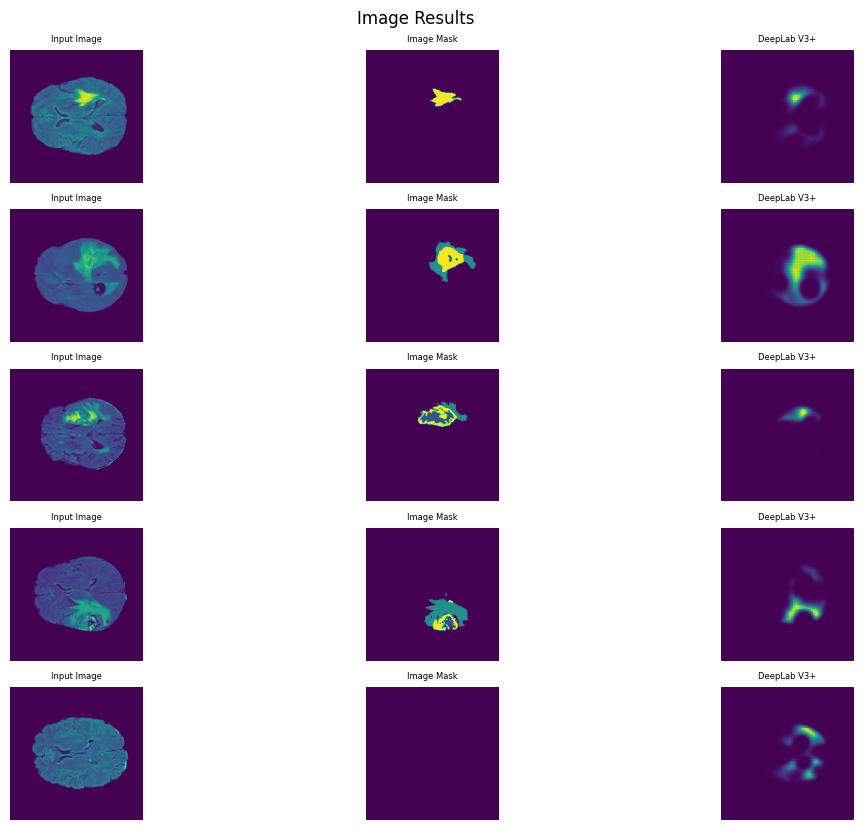

In [88]:
fig, axs = plt.subplots(5, 3, figsize=(13, 10))

for i in range(5):
    # # Original MRI Image
    # mri_sm = cv2.imread(test_img_samples[i])
    # axs[i, 0].imshow(mri_sm)
    # axs[i, 0].axis("off")
    # axs[i, 0].set_title("MRI Image", fontsize=6)
    
    # # Original Mask
    # mask_sm = cv2.imread(test_mask_samples[i])
    # axs[i, 1].imshow(mask_sm)
    # axs[i, 1].axis("off")
    # axs[i, 1].set_title("Original Mask", fontsize=6)
    
    for j in range(1):
        axs[i, j+0].imshow(X_test[i])
        axs[i, j+0].axis("off")
        axs[i, j+0].set_title("Input Image", fontsize=6)

        axs[i, j+1].imshow(Y_test[i])
        axs[i, j+1].axis("off")
        axs[i, j+1].set_title("Image Mask", fontsize=6)

        axs[i, j+2].imshow(predictions[0][i])
        axs[i, j+2].axis("off")
        axs[i, j+2].set_title(all_title[j], fontsize=6)

# Title
plt.suptitle("Image Results", x=0.5, y=0.92)

# Show
plt.show()